In [1]:
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc, log_loss
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [2]:
# Acessar o patch anterior ao patch do código e acessar a pasta "data"
PATH = os.path.join(os.path.dirname(os.getcwd()), "data")

In [3]:
def load_train_test_data(path=PATH):
    train_path = os.path.join(path, "train.csv")
    test_path = os.path.join(path, "test.csv")
    return pd.read_csv(train_path), pd.read_csv(test_path)

In [4]:
train, test = load_train_test_data(PATH)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.shape

(891, 12)

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
variables = train.drop("Survived", axis=1)
var_resp = train["Survived"].copy()

In [14]:
x_train, x_test, y_train, y_test = train_test_split(variables, var_resp, test_size=0.2, random_state=2)

In [15]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 30 to 168
Data columns (total 11 columns):
PassengerId    712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            564 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          160 non-null object
Embarked       710 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [16]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 707 to 251
Data columns (total 11 columns):
PassengerId    179 non-null int64
Pclass         179 non-null int64
Name           179 non-null object
Sex            179 non-null object
Age            150 non-null float64
SibSp          179 non-null int64
Parch          179 non-null int64
Ticket         179 non-null object
Fare           179 non-null float64
Cabin          44 non-null object
Embarked       179 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 16.8+ KB


In [21]:
columns = ["Cabin", "PassengerId", "Ticket", "Name"]

x_train.drop(columns, axis = 1, inplace = True)
x_test.drop(columns, axis = 1, inplace = True)

D:\Programas\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 30 to 168
Data columns (total 7 columns):
Pclass      712 non-null int64
Sex         712 non-null object
Age         564 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    710 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB


In [23]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 707 to 251
Data columns (total 7 columns):
Pclass      179 non-null int64
Sex         179 non-null object
Age         150 non-null float64
SibSp       179 non-null int64
Parch       179 non-null int64
Fare        179 non-null float64
Embarked    179 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 11.2+ KB


In [35]:
y_train.unique()

array([0, 1], dtype=int64)

In [24]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('oneHot', OneHotEncoder()),
    ])

In [25]:
num_attribs = x_train.select_dtypes(include=np.number).columns.tolist()
cat_attribs = x_train.select_dtypes(include='object').columns.tolist()

In [27]:
cat_attribs

['Sex', 'Embarked']

In [26]:
num_attribs

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [28]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [29]:
train_prepared = full_pipeline.fit_transform(x_train)

In [30]:
train_prepared

array([[-1.55247675,  0.82001539, -0.4668076 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.8349173 , -2.01049123,  0.42187424, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.8349173 ,  1.37039168, -0.4668076 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.55247675,  3.2573961 , -0.4668076 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.55247675, -0.06451793, -0.4668076 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.55247675, -0.06451793, -0.4668076 , ...,  0.        ,
         0.        ,  1.        ]])

In [31]:
train_prepared.shape

(712, 10)

In [42]:
test_prepared = full_pipeline.transform(x_test)

In [43]:
test_prepared

array([[-1.55247675,  0.97726576, -0.4668076 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.8349173 , -0.6738631 , -0.4668076 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.35877972, -0.43798755,  0.42187424, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.8349173 , -0.06451793,  6.64264713, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.8349173 , -0.28073718, -0.4668076 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.8349173 , -0.04486163,  0.42187424, ...,  0.        ,
         0.        ,  1.        ]])

In [33]:
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, linewidth=2, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falsos positivos', fontsize=16)
    plt.ylabel('Taxa de verdadeiros positivos', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

## Melhorando o desempenho com gridsearch e cross validation

In [37]:
class_weight_options = [None, 'balanced']
C_options = [0.001, 0.009, 0.01, 0.09, 0.1, 0.5, 1, 3, 5, 10, 50]

param_grid = dict(class_weight = class_weight_options, C = C_options)

log_reg = LogisticRegression(solver='lbfgs')
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, return_train_score=True)
grid_search = grid_search.fit(train_prepared, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.4s finished
D:\Programas\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
grid_search.best_params_

{'C': 0.1, 'class_weight': None}

In [39]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_predicted = grid_search.predict_proba(test_prepared)[:, 1]

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)

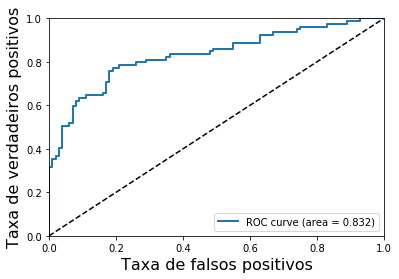

In [46]:
plot_roc_curve(fpr, tpr)

In [47]:
final_test = full_pipeline.transform(test)

In [50]:
final_test

array([[ 0.8349173 ,  0.38757688, -0.4668076 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.8349173 ,  1.37039168,  0.42187424, ...,  0.        ,
         0.        ,  1.        ],
       [-0.35877972,  2.54976944, -0.4668076 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.8349173 ,  0.70207762, -0.4668076 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.8349173 , -0.06451793, -0.4668076 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.8349173 , -0.06451793,  0.42187424, ...,  1.        ,
         0.        ,  0.        ]])

In [51]:
final_test.shape

(418, 10)

In [52]:
y_predicted_test = grid_search.predict(final_test)

In [53]:
y_predicted_test.shape

(418,)

In [54]:
y_predicted_test

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [56]:
test_passengerID = test['PassengerId'].copy()

In [57]:
dataset = pd.DataFrame({'PassengerId': test_passengerID, 'Survived': y_predicted_test})

In [58]:
dataset.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [59]:
dataset.to_csv('D:\\EPS\\Titanic-Kaggle\\data\\logreg_output.csv', sep=",", index=False)